# Changes:
1. Based on V36.1
2. Refactored data augmentor. Re-implement the rotate function to preserve positive mask area.

## Install required packages if running on google colab

In [1]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [2]:
cd salt_oil

[WinError 2] The system cannot find the file specified: 'salt_oil'
C:\Users\P768978\Desktop\work\code\study\salt_oil


## Import required libs

In [3]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import random
import PIL
import cv2 as cv
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [4]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.unet.resnet import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [5]:
## Setup data type based on whether GPU is enabled

In [6]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.FloatTensor'>


In [7]:
def setup_train(config_list):
    for conf in config_list:
        log.info(conf)
    for conf in config_list:
        exec(conf)

## Create Logger

In [8]:
global log
log = get_logger('salt_model_v37_refactor_aug_test1')

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [9]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


In [10]:
'''p = Pipeline_Salt()
p.random_brightness(1,0.8,1.2)
p.random_contrast(1,0.8,1.2)
p.rotate_random_align(probability=1)
img = np.c_[np.tile(X_train[840], 2), y_train[840]]
img_in = PIL.Image.fromarray(img)
tsfm = p.torch_transform()
img_out = tsfm(img_in)
plt.imshow(np.array(img_in)[:,:,0], cmap='gray')
plt.imshow(np.array(img_out)[:,:,0], cmap='gray')'''

"p = Pipeline_Salt()\np.random_brightness(1,0.8,1.2)\np.random_contrast(1,0.8,1.2)\np.rotate_random_align(probability=1)\nimg = np.c_[np.tile(X_train[840], 2), y_train[840]]\nimg_in = PIL.Image.fromarray(img)\ntsfm = p.torch_transform()\nimg_out = tsfm(img_in)\nplt.imshow(np.array(img_in)[:,:,0], cmap='gray')\nplt.imshow(np.array(img_out)[:,:,0], cmap='gray')"

### Train Val data split

In [11]:
df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])
df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)

X_train_ids, X_val_ids = (
    train_test_split(df_train_mask.index.tolist(), 
                     test_size=0.20,
                     stratify = df_train_mask.mask_pix,
                     random_state=0)
)

X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)
#set mean image to 0 as mean is now being handled within the model.
X_train_mean_img = np.zeros_like(X_train_mean_img)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

assert X_train_mean_img == np.array([0.])
assert X_train.shape == (3200, 101, 101, 1)
assert y_train.shape == (3200, 101, 101, 1)
assert depth_train.shape == (3200, 1)

## Train the model using a small data set to see if it can overfit

In [12]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.8, max_factor=1.0, mask_diff_pct=0.2)
'''

In [13]:
data_loader_config = '''
train_data_params = {'batch_size': 2, 'shuffle': True,}
val_data_params = {'batch_size': 2, 'shuffle': True,}
train_dataLoader = (
    DataLoader(SaltDataset(X_train[:16], y_train[:16], depth_train[:16],
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:8], y_val[:8], depth_val[:8], 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

'''

In [19]:
model_config = '''
saltnet = UResNet(pretrained=False)

loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)

#optimizer = optim.Adam([    
#    {'params': resnet_params, 'lr': 1e-4},
#    {'params': unet_params, 'lr': 1e-3},
#])
optimizer = optim.SGD([    
    {'params': resnet_params, 'lr': 1e-4},
    {'params': unet_params, 'lr': 1e-3},
], momentum=0.9, weight_decay=0.0001)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lr_lambda_enc, lr_lambda_dec])
scheduler = PolyLR(optimizer, [0.001,0.01], lr_decay_iter=1, max_iter=150, power=0.9)
model_save_name = None
'''

In [20]:
train_params_config = '''
train_params = {
    'model_save_name': None,
    'save_model_every': 10000,
    'save_log_every': 100,
    'num_epochs': 10,
    'print_every': 2,
    'log': log,
    'mask_cutoff': 0,
    'model_save_iou_threshold': 0.1
    }
'''

In [21]:
model_run_config = '''
model = train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.5), optimizer, scheduler, train_params, all_data)
'''

In [22]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

04/10/2018 23:22:03 - salt_model_v37_refactor_aug_test1 - INFO - 
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.8, max_factor=1.0, mask_diff_pct=0.2)

04/10/2018 23:22:03 - salt_model_v37_refactor_aug_test1 - INFO - 
train_data_params = {'batch_size': 2, 'shuffle': True,}
val_data_params = {'batch_size': 2, 'shuffle': True,}
train_dataLoader = (
    DataLoader(SaltDataset(X_train[:16], y_train[:16], depth_train[:16],
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:8], y_val[:8], depth_val[:8], 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_da

ResNetnot using pretrained weights.


04/10/2018 23:22:03 - salt_model_v37_refactor_aug_test1 - INFO - Start Training...
04/10/2018 23:22:03 - salt_model_v37_refactor_aug_test1 - INFO - ({'train': <torch.utils.data.dataloader.DataLoader object at 0x0000000045481080>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x0000000045481278>}, (BCEWithLogitsLoss(), LovaszHingeLoss()), (1, 0.5), SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
), <salt_func_lib.PolyLR object at 0x0000000046354630>, {'model_save_name': None, 'save_model_every': 10000, 'save_log_every': 100, 'num_epochs': 10, 'print_every': 2, 'log': <Logger salt_model_v37_refactor_aug_test1 (DEBUG)>, 'mask_cutoff': 0, 'model_save_iou_threshold': 0.1})
04/10/2018 23:22:03 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 1/10
04/10/2018 23:22:03 - salt_model_v37_refactor_aug_te

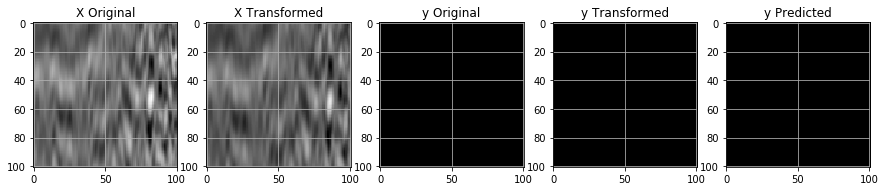

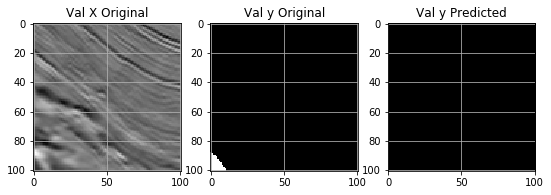

04/10/2018 23:22:32 - salt_model_v37_refactor_aug_test1 - INFO - Model state is not saved as the out_file_prefix is None
04/10/2018 23:22:32 - salt_model_v37_refactor_aug_test1 - INFO - Best Val Mean IOU so far: 0.125
04/10/2018 23:22:32 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 1
04/10/2018 23:22:32 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0099]
04/10/2018 23:22:32 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 2/10
04/10/2018 23:22:32 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 23:22:54 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8611, Loss: [0.7416, 0.5021, 1.2437] at epoch 2


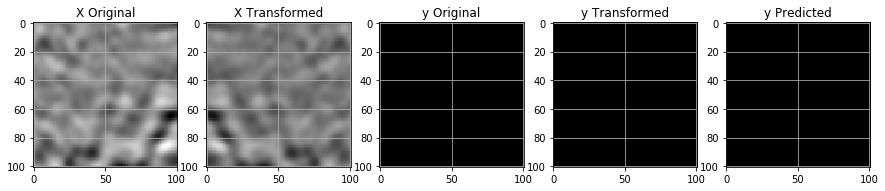

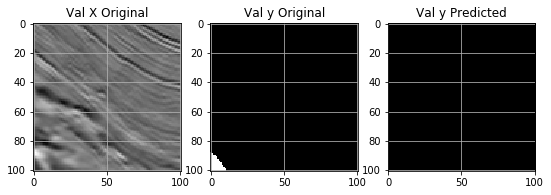

04/10/2018 23:23:00 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 2
04/10/2018 23:23:00 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0099]
04/10/2018 23:23:00 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 3/10
04/10/2018 23:23:00 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 23:23:23 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6250, Acc: 0.8590, Loss: [0.6804, 0.447, 1.1274] at epoch 3


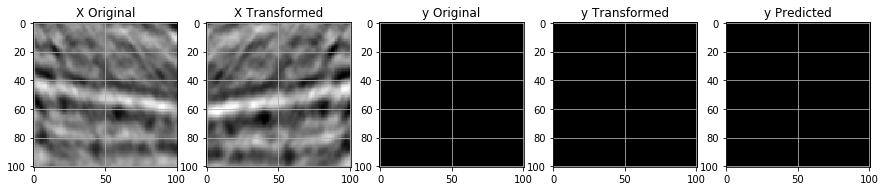

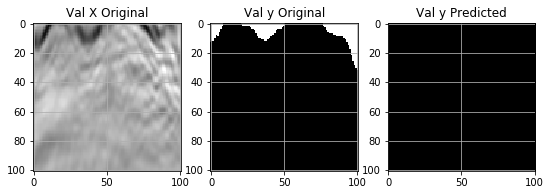

04/10/2018 23:23:28 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 3
04/10/2018 23:23:28 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0098]
04/10/2018 23:23:28 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 4/10
04/10/2018 23:23:28 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 23:23:52 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8535, Loss: [0.6776, 0.5806, 1.2582] at epoch 4


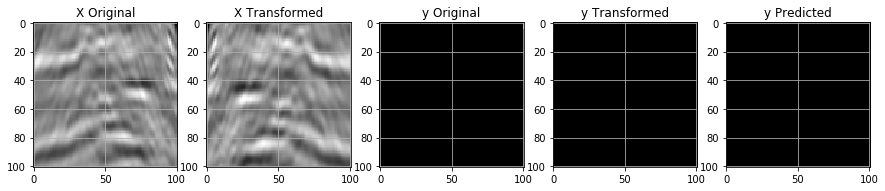

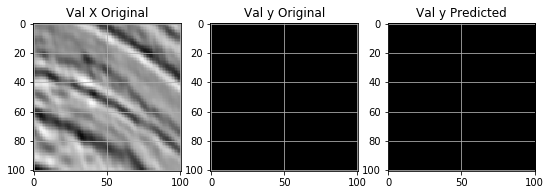

04/10/2018 23:23:58 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 4
04/10/2018 23:23:58 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0098]
04/10/2018 23:23:58 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 5/10
04/10/2018 23:23:58 - salt_model_v37_refactor_aug_test1 - INFO - --------------------


In [ ]:
setup_train(config_list)

## Train the full with full dataset

In [ ]:
log.info('Rerun the IOU 0.82 Unet34 baseline with grouped optimizer and refactored data aug')

In [ ]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.random_brightness(probability=0.5,0.8,1.2)
p.random_contrast(probability=0.5,0.8,1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.8, max_factor=1.0, mask_diff_pct=0.2)
'''

In [ ]:
data_loader_config = '''
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1,
                           transform=p.torch_transform()), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}
'''

In [ ]:
model_config = '''
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)

optimizer = optim.SGD([    
    {'params': resnet_params, 'lr': 1e-4},
    {'params': unet_params, 'lr': 1e-3},
], momentum=0.9, weight_decay=0.0001)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, min_lr=0.00001)
scheduler = PolyLR(optimizer, [0.001,0.01], lr_decay_iter=1, max_iter=150, power=0.9)
model_save_name = f'../salt_net/salt_model_v37_refactor_aug_test1_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)
'''

In [ ]:
train_params_config = '''
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 200,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.82
    }
'''

In [ ]:
model_run_config = '''
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)
'''

In [ ]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

In [ ]:
setup_train(config_list)